# Implementación del modelo SIR y su enfoque bayesiano a la coyuntura actual del nuevo Coronavirus SARS-Cov-2  

In [1]:

#Este código solo es para indicar la ruta en dónde se guardarán ls datos que se exportarán
import os 
path = 'C:/Users/Esteban/Documents/Pregrado_Estadìstica/Articulos tésis/Data/Colombia'
os.chdir(path)

Las librerías se instalan directamente desde la consola y se usa la instrucción
pip.install nombre_paquete, por ejemplo pip.install pandas

In [2]:
import pandas as pd  #EL paquete pandas es muy parecido a tidyverse de R
import sys # sistema
import json # datos provenientes en formato json
import ssl # formatos ssl
import numpy as np   # numpy es para las operaciones y arquitectura matemática
import plotly.graph_objects as go  #Gráficos
import plotly.express as px  #Gráficos interactivos, se uso una variedad distinta para darle mejor aspecto al doc
import matplotlib.pyplot as plt  #Gráficos menos visibles, pero son mas intuitivos, algunos no los use, o los deje comentados
from matplotlib import pyplot as plt
from matplotlib.dates import date2num, num2date #funciona para los labels
from matplotlib import dates as mdates
from matplotlib import ticker #
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from scipy.integrate import solve_ivp  #nos permite resolver ecuaciones diferenciales, de forma numérica
from scipy.optimize import minimize # minimizar el error cuadrático medio
from scipy.interpolate import interp1d
import seaborn as sns
from scipy import stats as sps
import scipy.stats as sta
import scipy.optimize
import statsmodels.stats.api as sms
import urllib.request
from datetime import timedelta, datetime  # cambiar el formate de la fecha


from IPython.display import clear_output

In [3]:
#Estos datos son traidos directamente desde el repositorio del instituo hopkings.
confirmados = 'https://data.humdata.org/hxlproxy/api/data-preview.csv?url=https%3A%2F%2Fraw.githubusercontent.com%2FCSSEGISandData%2FCOVID-19%2Fmaster%2Fcsse_covid_19_data%2Fcsse_covid_19_time_series%2Ftime_series_covid19_confirmed_global.csv&filename=time_series_covid19_confirmed_global.csv'
muertos = 'https://data.humdata.org/hxlproxy/api/data-preview.csv?url=https%3A%2F%2Fraw.githubusercontent.com%2FCSSEGISandData%2FCOVID-19%2Fmaster%2Fcsse_covid_19_data%2Fcsse_covid_19_time_series%2Ftime_series_covid19_deaths_global.csv&filename=time_series_covid19_deaths_global.csv'
recuperados = 'https://data.humdata.org/hxlproxy/api/data-preview.csv?url=https%3A%2F%2Fraw.githubusercontent.com%2FCSSEGISandData%2FCOVID-19%2Fmaster%2Fcsse_covid_19_data%2Fcsse_covid_19_time_series%2Ftime_series_covid19_recovered_global.csv&filename=time_series_covid19_recovered_global.csv'

In [25]:
pais = input()

Colombia


In [4]:
df = pd.read_csv(confirmados)
df[df['Country/Region'] == 'Brazil']

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,7/6/20,7/7/20,7/8/20,7/9/20,7/10/20,7/11/20,7/12/20,7/13/20,7/14/20,7/15/20
28,NaN,Brazil,-14.235,-51.9253,0,0,0,0,0,0,...,1623284,1668589,1713160,1755779,1800827,1839850,1864681,1884967,1926824,1966748


# Implementación Modelo SIR

Con el fin de que el usuario entienda un poco mas como se usa el paquete scipy y su método de resolver ecuaciones diferenciales
presento un ejemplo de aplicación.
Considere las siguientes Ecuaciones diferenciales con valor inicial, ecuaciones muy conocidas.
$\frac{dx}{dt} = cos(y) $ y $\frac{dy}{dt} = sin(x)$ con $x(0) = y(0) = 1$

In [3]:
#Definimos la función que tiene las ecuaciones, el orden cambia, primero es t = tiempo y luego el parámetros
def f(t,r):
    x,y = r
    fx = np.cos(y)
    fy = np.sin(x)
    return fx, fy

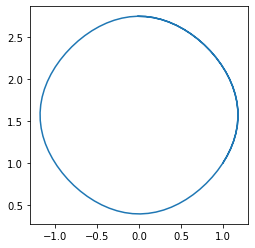

In [4]:
sol = solve_ivp(f,(0,10), (1,1), t_eval = np.linspace(0,10,100)) #los argumentos son, la funciín, el rango del valor inicial, los
                                                                #puntos iniciales y el rango de soliciones posibles
x,y = sol.y
plt.plot(x,y)
plt.axis('scaled')
plt.show()

Para la implementanción de estos códigos, se tomaron ideas y ayudas de las siguientes páginas
https://www.lewuathe.com/covid-19-dynamics-with-sir-model.html
https://scipython.com/book/chapter-8-scipy/additional-examples/the-sir-epidemic-model/

In [5]:
class Modelo_Sir:
    def __init__(self, pais, perdida, fecha_inicial ='3/5/20', rango_prediccion = 150,s_0 = 100000, i_0 = 65, r_0 = 1):
        self.pais = pais
        self.perdida = perdida
        self.fecha_inicial = fecha_inicial
        self.rango_prediccion = rango_prediccion
        self.s_0 = s_0
        self.i_0 = i_0
        self.r_0 = r_0

    def confirmados_modelo(self, pais):   #### lo que hacemos es disponer de los datos de forma que en una 
        df = pd.read_csv(confirmados)     #### una columna estén las fechas y en la otra la serie acumulativa 
        df = df.drop(['Province/State'],axis =1)
        pais_df = df[df['Country/Region'] == pais]
        return pais_df.iloc[0].loc[self.fecha_inicial:]


    def recuperados_modelo(self, pais):
        df = pd.read_csv(recuperados)
        df = df.drop(['Province/State'],axis =1)
        pais_df = df[df['Country/Region'] == pais]
        return pais_df.iloc[0].loc[self.fecha_inicial:]


    def muertos_modelo(self, pais):
        df = pd.read_csv(muertos)
        df = df.drop(['Province/State'],axis =1)
        pais_df = df[df['Country/Region'] == pais]
        return pais_df.iloc[0].loc[self.fecha_inicial:]
    
    """
    La función indice_Extension permite ampliar el índice desde la fecha inicial , por eso 
    en los parámetros iniciales se pone rango_prediccion, de tal forma que esa es la cantidad 
    de dias en los que se hará la predicción.
    """

    def indice_extension(self, index, nuevo_tamaño):
        values = index.values
        actual = datetime.strptime(index[-1], '%m/%d/%y')
        while len(values) < nuevo_tamaño:
            actual = actual + timedelta(days=1)
            values = np.append(values, datetime.strftime(actual, '%m/%d/%y'))
        return values

    def Prediccion_modelo(self, beta, gamma, data, recuperado, muerto, pais, s_0, i_0, r_0):
        """
       Predecir cómo se puede cambiar el número de personas en cada compartimiento a través del tiempo hacia el futuro.
        El modelo está formulado con los beta y gamma dados
        """
        nuevo_indice = self.indice_extension(data.index, self.rango_prediccion)
        size = len(nuevo_indice)
        def SIR(t, y):
            S = y[0]
            I = y[1]
            R = y[2]
            return [-beta*S*I, beta*S*I-gamma*I, gamma*I]
        actual_extendido = np.concatenate((data.values, [None] * (size - len(data.values))))
        recuperado_extendido = np.concatenate((recuperado.values, [None] * (size - len(recuperado.values))))
        muerto_extendido = np.concatenate((muerto.values, [None] * (size - len(muerto.values))))
        return nuevo_indice, actual_extendido, recuperado_extendido, muerto_extendido, solve_ivp(SIR, [0, size], [s_0,i_0,r_0], t_eval=np.arange(0, size, 1))
    
    def entrenamiento(self):
        """
         Ejecute la optimización para estimar el ajuste beta y gamma de los casos confirmados dados
        """
        recuperado = self.recuperados_modelo(self.pais)
        muerto = self.muertos_modelo(self.pais)
        data = (self.confirmados_modelo(self.pais) - recuperado - muerto)
        
        optimo = minimize(
            perdida, 
            [0.001, 0.001], 
            args=(data, recuperado, self.s_0, self.i_0, self.r_0), 
            method='L-BFGS-B', 
            bounds=[(0.00000001, 0.5), (0.00000001, 0.5)]
        )
        print(optimo)
        beta, gamma = optimo.x
        nuevo_indice, actual_extendido, recuperado_extendido, muerto_extendido, prediccion = self.Prediccion_modelo(beta, gamma, data, recuperado, muerto, self.pais, self.s_0, self.i_0, self.r_0)
        df = pd.DataFrame({'Infectados': actual_extendido, 'recuperados': recuperado_extendido, 'muertos': muerto_extendido, 'Susceptible': prediccion.y[0], 'Infectados_pronostico': prediccion.y[1], 'recuperado_pronostico': prediccion.y[2]}, index=nuevo_indice)
        df.to_csv(f"{self.pais}.csv")
        fig, ax = plt.subplots(figsize=(13, 8))
        ax.set_title(self.pais)
        df.plot(ax=ax)
        print(f"pais={self.pais}, beta={beta:.8f}, gamma={gamma:.8f}, r_0:{(beta/gamma):.8f}")
        fig.savefig(f"{self.pais}.png")
        
        return df, fig

    
def perdida(puntos, data, recuperado, s_0, i_0, r_0):
    size = len(data)
    beta, gamma = puntos
    def SIR(t, y):
        S = y[0]
        I = y[1]
        R = y[2]
        return [-beta*S*I, beta*S*I-gamma*I, gamma*I]
    solucion = solve_ivp(SIR, [0, size], [s_0,i_0,r_0], t_eval=np.arange(0, size, 1), vectorized=True)
    l1 = np.sqrt(np.mean((solucion.y[1] - data)**2))
    l2 = np.sqrt(np.mean((solucion.y[2] - recuperado)**2))
    alpha = 0.1
    return alpha * l1 + (1 - alpha) * l2


      fun: 3677.641918860451
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([3.58973048e+11, 3.42307309e+04])
  message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 291
      nit: 14
   status: 2
  success: False
        x: array([3.19965630e-07, 4.20720876e-02])
pais=Colombia, beta=0.00000032, gamma=0.04207209, r_0:0.00000761


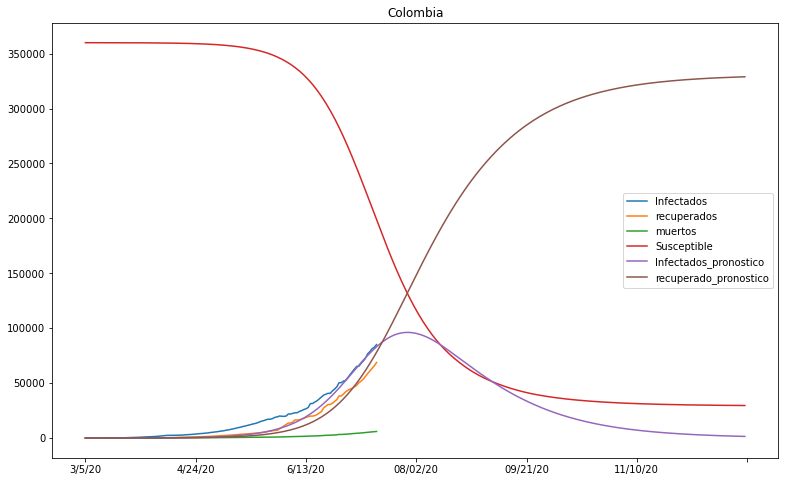

In [17]:
Colombia_sir1 = Modelo_Sir(pais="Colombia", perdida= perdida,rango_prediccion=300,s_0=360000, i_0=15, r_0=4 )
Colombia_df1, Colombia_fig1 = Colombia_sir1.entrenamiento()

In [28]:
Colombia_df1.iloc[118:140:,]

,Infectados,recuperados,muertos,Susceptible,Infectados_pronostico,recuperado_pronostico
7/1/20,52459,42143,3488,269841.874815,52338.721798,37838.403388
7/2/20,55130,43481,3650,265250.517406,54683.835028,40084.647566
7/3/20,57935,44606,3851,260547.522741,57042.099177,42429.378082
7/4/20,60383,45409,4001,255741.740288,59404.095593,44873.164119
7/5/20,62864,46643,4178,250842.215160,61760.586982,47416.197858
7/6/20,65146,47961,4305,245858.188109,64102.517414,50058.294477
7/7/20,65459,50370,4452,240799.095525,66421.012318,52798.892157
7/8/20,68027,51861,4606,235674.569443,68707.378483,55637.052075
7/9/20,70213,53634,4791,230494.437533,70953.104059,58571.458407
7/10/20,72716,56272,4985,225268.723110,73149.858559,61600.418331


      fun: 3887.6322349434495
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([1.71812137e+11, 4.74261389e+05])
  message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 315
      nit: 15
   status: 2
  success: False
        x: array([3.19425215e-07, 3.94946187e-02])
pais=Colombia, beta=0.00000032, gamma=0.03949462, r_0:0.00000809


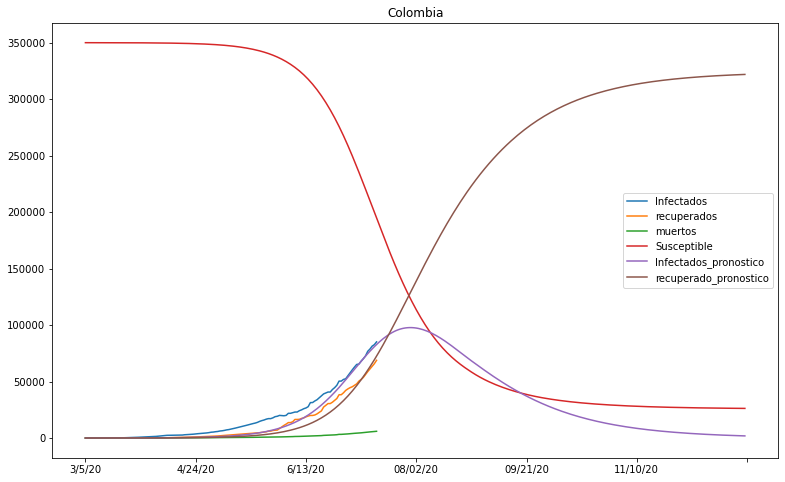

In [7]:
Colombia_sir = Modelo_Sir(pais="Colombia", perdida= perdida,rango_prediccion=300,s_0=350000, i_0=16, r_0=4 )
Colombia_df, Colombia_fig = Colombia_sir.entrenamiento()

In [27]:
Colombia_df.iloc[110:140:,]

,Infectados,recuperados,muertos,Susceptible,Infectados_pronostico,recuperado_pronostico
6/23/20,40719,30517,2524,293834.479883,34572.346997,21613.173120
6/24/20,40719,30517,2524,290516.365257,36488.651220,23014.983523
6/25/20,42973,31729,2611,287058.945424,38467.583450,24493.471126
6/26/20,44615,33410,2786,283461.951915,40506.661252,26051.386833
6/27/20,46715,34999,2946,279725.460405,42603.035353,27691.504242
6/28/20,50394,38345,3256,275847.009647,44756.681647,29416.308706
6/29/20,50394,38345,3256,271820.765267,46972.012623,31227.222109
6/30/20,51872,40021,3376,267654.658662,49239.198509,33126.142829
7/1/20,52459,42143,3488,263357.762626,51547.510716,35114.726657
7/2/20,55130,43481,3650,258939.217182,53886.482750,37194.300067


# Implementación modelo bayesiano

Acá empieza la implementación del modelo Bayesiano, dada las nuevas actualizaciones se recomienda y se da todo el crédito a Kevin Systrom
Pueden consultar su código en el siguiente link.
https://github.com/k-sys/covid-19/blob/master/Realtime%20Rt%20mcmc.ipynb
Los comentarios son solo una guía de lo que hace cada linea de comando.

In [4]:
'Esta función hace que los datos traidos del repositorio Hopkings se vean mucho mas presentable'
def base_mejorada(base, nombre = 'cases' , colAgrup = 1, nombre_colu = 'country'):  #Trabajaremos con los dos primeros
    eliminar_colum = ['Lat', 'Long'] #Estas son las columnas que encontré en las bases , las cuales no usé
    eliminar_vec = [] #Se crea una lista ir guardando los elementos que vamos a eliminar
    df = pd.read_csv(base, index_col = None)
    for i in eliminar_colum:
        if i in df.columns:
            eliminar_vec.append(i) #con append, lo que hacemos es agregar cada elemento a una lista.
    df = df.drop(eliminar_vec,axis = 1) #Eliminamos de la base que introduzcamos aquellas columnas
    df=df.set_index([*df.columns[:2]]) # indexamos 
    df=df.stack().reset_index() #Restablecemos los indidces y volvemos todos los niveles, de esta forma numeramos todos los paises
    df.columns=[*df.columns[:2],'date',nombre] # Nombramos las columnas
    df.date=pd.to_datetime(df.date) #Convertimos a formato fecha
    
    df=df.groupby([df.columns[colAgrup],'date']).sum().reset_index() #Agrupamos por la columna 1, es decir por país y sumamos los casos
    df.columns=[nombre_colu,*df.columns[1:]]
    return df
    

In [5]:
#Acá se pone el nombre del país al cuál se le hará el estudio bayesiano
nombre_pais = 'Colombia'
df_confirmados = base_mejorada(confirmados)
confirmados_b = df_confirmados[df_confirmados['country'] == nombre_pais].set_index(['country', 'date']).sort_index().T.iloc[0]


In [6]:
def depuracion_casos(cases, orden = 25):
    new_cases = cases.diff() #Se hace una diferenciia entre el día actual menos el anterior
    #La función rolling aplicada a la serie, permite encontrar un suavizado de tipo gaussiano
    #Observe que escogimos 7, porque son los días, es decir, la estimación se hace semanal
    suavizado = new_cases.rolling(7,
        win_type = 'gaussian',
        min_periods = 1,
        center = True).mean(std = 2).round()
    
    idx_start = np.searchsorted(suavizado, orden)
    
    suavizado = suavizado.iloc[idx_start:]
    original = new_cases.loc[suavizado.index]
    
    return original, suavizado

cases = confirmados_b.xs(nombre_pais).rename(f"{nombre_pais} casos confirmados")

original, suavizado = depuracion_casos(cases)

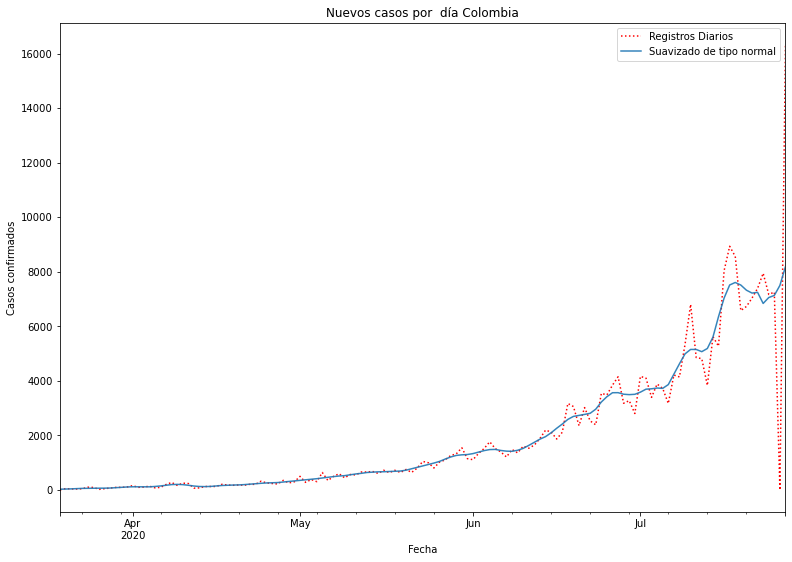

In [7]:
original.plot(title = "Nuevos casos por  día Colombia",
               c = 'r',
               linestyle = ':',
               alpha = 1,
               label = 'Registros Diarios',
               legend = True,
             figsize = (13,9))
suavizado.plot(label = 'Suavizado de tipo normal', alpha = 0.9,
                   legend = True)
plt.xlabel('Fecha')
plt.ylabel('Casos confirmados');

In [13]:
GAMMA = 1/7
R_T_MAX = 12
r_t_range = np.linspace(0, R_T_MAX, R_T_MAX*100+1)
def funcion_posteriori(sr, sigma = 0.30):

    # calcular lambda según la metodoogía planteada
    lam = sr[:-1].values * np.exp(GAMMA * (r_t_range[:, None] - 1))

    
    # (2) calcular cada día la verosimilitud
    verosimil = pd.DataFrame(
        data = sps.poisson.pmf(sr[1:].values, lam),
        index = r_t_range,
        columns = sr.index[1:])
    
    # (3) una matriz normal
    matriz_proceso = sps.norm(loc = r_t_range,
                              scale = sigma
                             ).pdf(r_t_range[:, None]) 

    # (3a) la suma a 1
    matriz_proceso /= matriz_proceso.sum(axis=0)
    
    # (4) calcular la priori inicial
    prior0 = sps.gamma(a=4).pdf(r_t_range)
    prior0 /= prior0.sum()

    # un data.frame con las posteriori
    posteriors = pd.DataFrame(
        index=r_t_range,
        columns=sr.index,
        data={sr.index[0]: prior0}
    )
    
    
    log_verosi = 0.0

    # (5) bayes iterativamente 
    for dia_previo, dia_actual in zip(sr.index[:-1], sr.index[1:]):

        #(5a) nueva apriori
        current_prior = matriz_proceso @ posteriors[dia_previo]
        
        #(5b) numerador de bayes: P(k|R_t)P(R_t)
        numerator = verosimil[dia_actual] * current_prior
        
        #(5c) denominador de Bayes'  P(k)
        denominator = np.sum(numerator)
        
        # Regla de bayes
        posteriors[dia_actual] = numerator/denominator
        
        #  log verosimil
        log_verosi += np.log(denominator)
    
    return posteriors, log_verosi # Luego las posteriors serían una matriz donde las columnas son los días y las filas son los 
                                 #R_ts, luego, si se grafica una columna cada vez se encontrará una función a posterior para cada día

posteriors, log_verosi = funcion_posteriori(suavizado, sigma=.25)

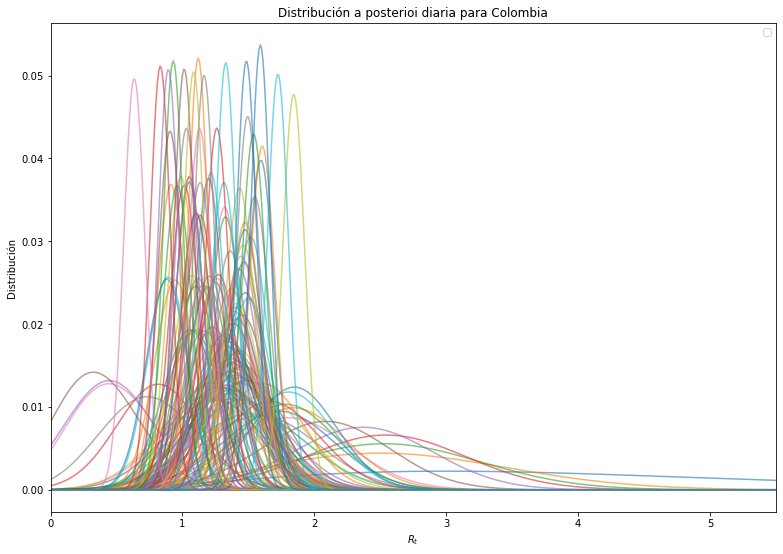

In [14]:
posteriors.plot(title="Distribución a posterioi diaria para Colombia", alpha=.6, xlim=(0,5.5), figsize = (13,9),
               linestyle='solid')
plt.legend('')
plt.xlabel('$R_t$')
plt.ylabel('Distribución')
plt.show()

In [24]:
def intervalo_credibilidad_mayor(pmf, p=.9, debug=False):
    if(isinstance(pmf, pd.DataFrame)):
        return pd.DataFrame([intervalo_credibilidad_mayor(pmf[col], p=p) for col in pmf],
                            index=pmf.columns)
    
    valores = pmf.values
    cumsum = np.cumsum(valores)#Acumular los valores, por ejemplo
                               #np.cumsum([1,2,3]) = [1,3,6]
    
    # Matriz de probabilidad
    total_p = cumsum - cumsum[:, None] #Esto crea una matriz de tamaño nxn, n = días de contagio
    
    # devuelve los índices en dónde
    lows, highs = (total_p > p).nonzero() #devuelve los índices dónde las entradas de la matriz es mayor que 0.9
    
    # encontrar el mejor, (mayor densidad)
    best = (highs - lows).argmin()
    
    low = pmf.index[lows[best]] #Se busca en dónde está el valor que hace mínimo el argumento, análogo con high
    high = pmf.index[highs[best]]
    
    return pd.Series([low, high],
                     index=[f'Low_{p*100:.0f}',
                            f'High_{p*100:.0f}'])

ic_mayor = intervalo_credibilidad_mayor(posteriors, p=.9)

most_likely = posteriors.idxmax().rename('ML')

result = pd.concat([most_likely, ic_mayor], axis=1)

result.tail(10)

,ML,Low_90,High_90
date,,,
2020-07-06,0.95,0.77,1.12
2020-07-07,1.19,1.00,1.35
2020-07-08,1.61,1.42,1.76
2020-07-09,1.61,1.44,1.76
2020-07-10,1.57,1.40,1.71
2020-07-11,1.29,1.11,1.42
2020-07-12,1.05,0.87,1.18
2020-07-13,0.91,0.73,1.04
2020-07-14,0.84,0.67,0.98


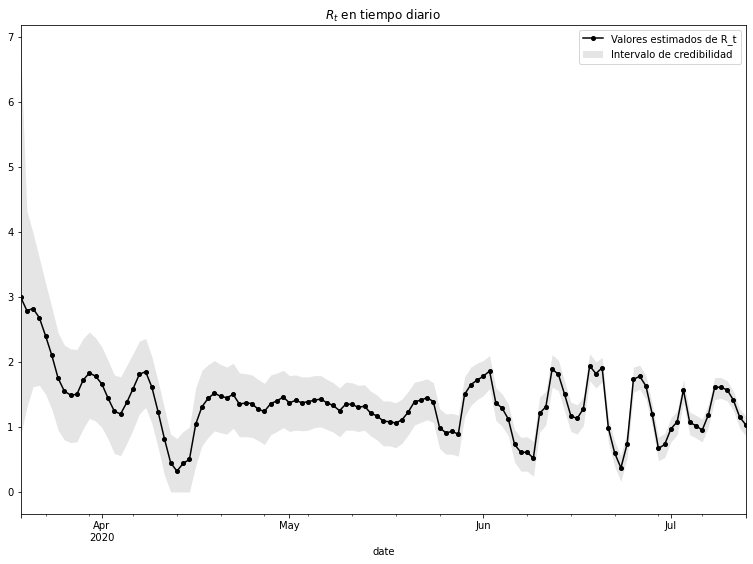

In [15]:
#En lo personal graficaría de la siguiente forma la distribución de R_t, existe un código mas sofisticado, que lo diseñó 
#Kevin Systrom para graficar intervalos de credibilidad

ax = most_likely.plot(marker = 'o',figsize = (13,9),
                             label = 'Valores estimados de R_t',
                             title = f'$R_t$ en tiempo diario',
                             c = 'k',
                             markersize = 4)

ax.fill_between(ic_mayor.index,
                ic_mayor['Low_90'],
                ic_mayor['High_90'],
                color = 'k',
                alpha = .1,
                lw = 0,
                label='Intervalo de credibilidad')

ax.legend();

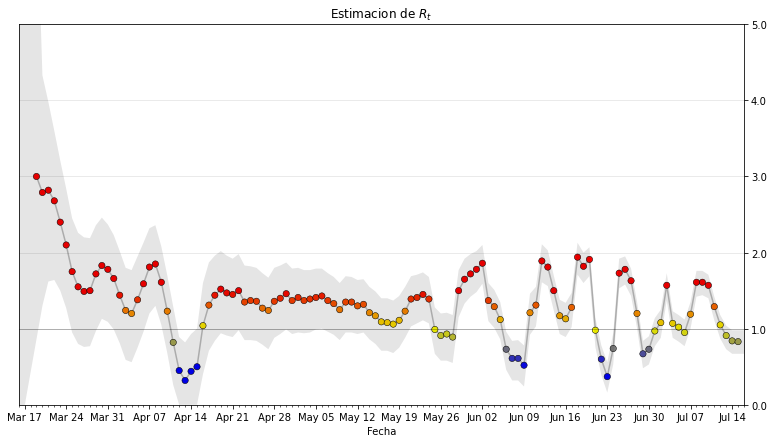

In [25]:
#El siguiente gráfico es una versión de un código que ya existe y se puede consultar en la página de Kevin Systrom


def plot_rt(result, ax, nombre_pais):
    
    ax.set_title(f"{nombre_pais}")
    
    # Colores
    ABOVE = [1,0,0]
    MIDDLE = [1,1,0]
    BELOW = [0,0,1]
    cmap = ListedColormap(np.r_[
        np.linspace(BELOW,MIDDLE,25),
        np.linspace(MIDDLE,ABOVE,25)
    ])
    color_mapped = lambda y: np.clip(y, .5, 1.5)-.5
    
    index = result['ML'].index.get_level_values('date')
    values = result['ML'].values
    
    # Gráficos de líneas y de puntos
    ax.plot(index, values, c='k', zorder=1, alpha=.25)
    ax.scatter(index,
               values,
               s=40,
               lw=.5,
               c=cmap(color_mapped(values)),
               edgecolors='k', zorder=2)
    
    
    lowfn = interp1d(date2num(index),
                     result['Low_90'].values,
                     bounds_error=False,
                     fill_value='extrapolate')
    
    highfn = interp1d(date2num(index),
                      result['High_90'].values,
                      bounds_error=False,
                      fill_value='extrapolate')
    
    extended = pd.date_range(start=pd.Timestamp('2020-03-01'),
                             end=index[-1]+pd.Timedelta(days=1))
    #####
    ##### esta expresión nos permite adecuado el intervalo de credibilidad para cada $R_T$
    ax.fill_between(extended,
                    lowfn(date2num(extended)),
                    highfn(date2num(extended)),
                    color='k',
                    alpha=.1,
                    lw=0,
                    zorder=3)

    ax.axhline(1.0, c='k', lw=1, label='$R_t=1.0$', alpha=.25);
    
    # Formato
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.tick_right()
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['right'].set_visible(True)
    ax.margins(0)
    ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
    ax.margins(0)
    ax.set_ylim(0.0, 5.0)
    ax.set_xlim(pd.Timestamp('2020-03-16'), result.index.get_level_values('date')[-1]+pd.Timedelta(days=1))
    fig.set_facecolor('w')

    
fig, ax = plt.subplots(figsize=(13,7))

plot_rt(result, ax, nombre_pais)
ax.set_title('Estimacion de $R_t$')
ax.xaxis.set_major_locator(mdates.WeekdayLocator()) #Se usa para dejar en formto semanas
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d')) #Formato para dejar solo día y mes
ax.set_xlabel('Fecha');


# Comparación del modelo Bayesiano con el proceso MCMC

In [17]:
link = 'https://covidtracking.com/api/v1/states/daily.csv'
base  = pd.read_csv(link,
                     usecols=['date', 'state', 'positive'],
                     parse_dates=['date'],
                     index_col=['state', 'date'],
                     squeeze=True).sort_index()

In [18]:
nombre_pais = 'CA'
cases = base.xs(nombre_pais).rename(f"{nombre_pais} casos confirmados")

original1, suavizado1 = depuracion_casos(cases)

In [19]:
posteriors1, log_verosi1 = funcion_posteriori(suavizado1, sigma=.25)

In [20]:
ic_mayor = intervalo_credibilidad_mayor(posteriors1, p=.9)

most_likely = posteriors1.idxmax().rename('ML')

result = pd.concat([most_likely, ic_mayor], axis=1)

result.tail(10)

,ML,Low_90,High_90
date,,,
2020-07-04,0.95,0.80,1.06
2020-07-05,1.19,1.06,1.31
2020-07-06,1.27,1.13,1.38
2020-07-07,1.22,1.07,1.32
2020-07-08,1.11,0.99,1.23
2020-07-09,1.00,0.87,1.11
2020-07-10,0.79,0.64,0.89
2020-07-11,1.01,0.87,1.12
2020-07-12,0.88,0.74,0.99
